In [2]:
#Import Modules
import pandas as pd 
import matplotlib.pyplot as plt
import panel as pn
from panel.interact import interact
import plotly.express as px
pn.extension("plotly")
import hvplot.pandas
%matplotlib inline

In [3]:
# Define function for analyzing Unemployment Insurance Claims 
def insurance_claims():
    unemployment_insurance_data=pd.read_csv('resources/Unemployment Insurance.csv',parse_dates=True,infer_datetime_format=True,index_col='DATE')
    unempl_claims_last2yrs = unemployment_insurance_data.loc[unemployment_insurance_data.index > '2018-01-01']
    return unempl_claims_last2yrs.hvplot(kind='line', 
                                         title='Unemployment Insurance Claims (2018-2020)',
                                         rot=90,
                                         xlabel = 'Date',
                                         ylabel = 'Insurance Claims',
                                         height = 400
                                        )

In [4]:
# Define function for analyzing change in Unemployment Rate
def unemployment_rate():
    unemployment_rate=pd.read_csv('resources/Unemployment Rate.csv',parse_dates=True,infer_datetime_format=True,index_col='DATE')
    unempl_rate_last2yrs = unemployment_rate.loc[unemployment_rate.index > '2018-01-01']
    unempl_rate_last2yrs = unempl_rate_last2yrs.rename(columns={'UNRATE':'unempl_rate'})
    unempl_rate_plot = unempl_rate_last2yrs.hvplot(kind='bar',
                                        rot=90,
                                        title='Unemployment Rate (2018-2020)',
                                        xlabel = 'Date',
                                        ylabel = 'Unemployment Rate',
                                        height = 400
                                       )
    
    return unempl_rate_plot

In [5]:
# Define function for analyzing COVID Data
def covid_data(string):
    all_covid_data=pd.read_csv('resources/covid_data.csv')
    usa_covid_data=all_covid_data.loc[all_covid_data['iso_code'] == 'USA']
    usa_covid_data=usa_covid_data.rename(columns={"date":"DATE"})
    usa_covid_data=usa_covid_data.dropna()
    usa_covid_data=usa_covid_data.set_index('DATE')
    usa_covid_data.index = pd.to_datetime(usa_covid_data.index)

    usa_covid_stats = usa_covid_data.filter(items=['total_cases','total_deaths'])
    usa_covid_stats_by_month = usa_covid_stats.groupby([pd.Grouper(freq='M')])['total_cases','total_deaths'].sum()
    
    if string == 'Daily':
        return usa_covid_stats
    elif string == 'Monthly':
        return usa_covid_stats_by_month

In [6]:
# Define function for analyzing Mobility Data
def mobility_data():
    mobility_data = pd.read_csv('resources/2020_US_Region_Mobility_Report.csv',index_col='date',infer_datetime_format=True,parse_dates=True)
    mobility_data = mobility_data.filter(['date','retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline'])
    mobility_data.rename(columns={'retail_and_recreation_percent_change_from_baseline':'Retail_Recreation','grocery_and_pharmacy_percent_change_from_baseline':'Grocery_Pharmacy','parks_percent_change_from_baseline':'Parks','transit_stations_percent_change_from_baseline':'Public_Transit','workplaces_percent_change_from_baseline':'Workplaces','residential_percent_change_from_baseline':'Residential'},inplace=True)
    mobility_data.dropna(inplace=True)
    mobility_data_by_month = mobility_data.groupby([pd.Grouper(freq='M')])['Retail_Recreation','Grocery_Pharmacy','Parks','Public_Transit','Workplaces','Residential'].sum()
    return mobility_data_by_month

In [7]:
# Define function for parallel coordinates
def covid_mobility_parallel():
    usa_covid_stats_by_month = covid_data('Monthly')
    mobility_data_by_month = mobility_data()
    covid_mobility_grp = pd.concat([usa_covid_stats_by_month,mobility_data_by_month],join='inner',axis=1)
    covid_mobility_grp.reset_index()
    
    return px.parallel_coordinates(
        covid_mobility_grp,
        dimensions = ['total_cases','Retail_Recreation','Grocery_Pharmacy','Parks','Public_Transit','Workplaces'],
        color = 'total_cases',
        color_continuous_scale = px.colors.sequential.Inferno,
        height = 700
    )
    
       

In [8]:
# replacing all empty sub-regions which represent the entire US with code 'ALL'
def cleaning_mobility():
    mobility_data = pd.read_csv('resources/2020_US_Region_Mobility_Report.csv',
                                index_col = 'date',
                                parse_dates = True,
                                infer_datetime_format = True)
    mobility_data['sub_region_1'].fillna(value ='ALL', inplace=True)
    mobility_data.drop(columns=[
        'country_region_code',
        'metro_area','census_fips_code',
        'country_region_code',
        'transit_stations_percent_change_from_baseline',
        'iso_3166_2_code',
        'parks_percent_change_from_baseline',
        'residential_percent_change_from_baseline'], 
        inplace = True)
    # keeping the null values, reverse cleaning. Weird df 
    nan_filter = mobility_data["sub_region_2"].isna()
    mobility_data = mobility_data[nan_filter]
    mobility_data.reset_index()
    mobility_data = mobility_data.rename(
    columns ={
        'retail_and_recreation_percent_change_from_baseline':'Retail and Recreation',
        'grocery_and_pharmacy_percent_change_from_baseline':'Grocery and Pharmacy',
        'workplaces_percent_change_from_baseline': 'Workplaces',
        'sub_region_1':'State'}) 
    return mobility_data

In [9]:
# ploting the mobility mean
def mobility_mean_graph():
    mobility_data = cleaning_mobility()
    mobility_mean = mobility_data.groupby("State")['Retail and Recreation'].mean()
    bar1 = mobility_mean.plot(
    kind='bar', 
    figsize = (12,10), 
    ylabel = 'Average Per Cent Change',
    title= 'Average Per Cent Change of Travel for Retail and Recreation'
    )
    return (bar1)

In [10]:
# this shows the mobilty and different approachs to lockdown actions i.e Rebulican vs. Democratic 
def mobility_mean_sort():
    mobility_data = cleaning_mobility()
    mobility_mean = mobility_data.groupby("State")['Retail and Recreation'].mean()
    # sorting values to then plot 
    mobility_meanSort=mobility_mean.sort_values(ascending = False)
    state_meanSort = mobility_meanSort.plot(
    kind='bar', 
    figsize = (12,10), 
    #ylabel = 'Average Per Cent Change',
    title = 'Average Per Cent Change of Travel for Retail and Recreation'
    )
    return (state_meanSort)

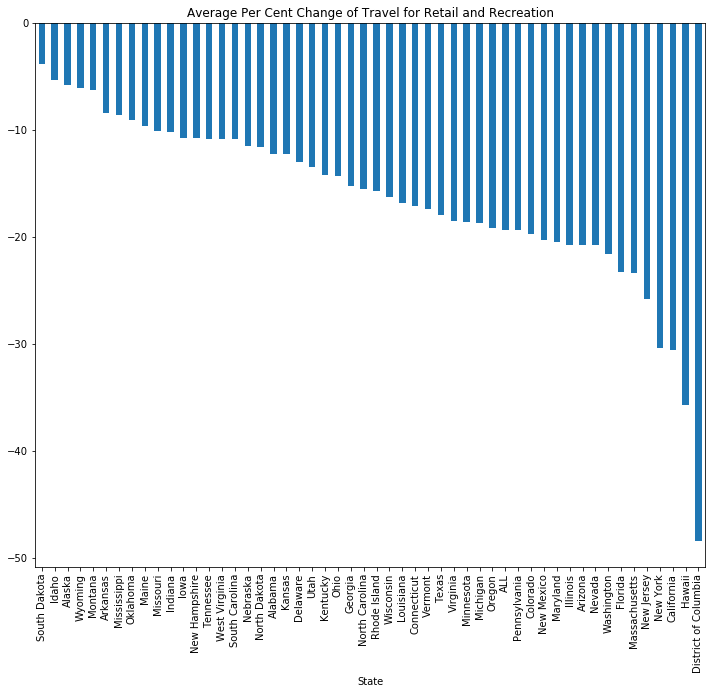

In [11]:
mobility_mean_sort()

In [12]:
def normalizedStock_plot():
    US_ALL = mobility_data.loc[mobility_data.State == 'ALL','Retail and Recreation']
    tickers = ['ETSY', 'M', 'JWN','AMZN', 'WMT', 'PRTY']
    start_date = dt.date(2020,2,15)
    end_date = dt.date(2021,1,26)
    close_prices = pdr.data.get_data_yahoo(
    tickers,
    start_date,
    end_date,
    )["Adj Close"]
    normalized_close=(close_prices-close_prices.min())/(close_prices.max()-close_prices.min())
    prices_plot = normalized_close.hvplot(x='Date', title='Normalized Stock Prices')
    return prices_plot 


In [13]:
def amzn_plt():
    mobility_data = cleaning_mobility()
    import matplotlib. pyplot as plt
    US_ALL.rename('US Mobility Daily Per Cent Change')
    df = pd.DataFrame(US_ALL)
    stock_mobility = pd.concat([df,close_prices],axis = 1, join = 'inner')
    stock_mobility.rename(columns={'Retail and Recreation': 'US Retail Mobility '}, inplace = True)
    fig,ax = plt.subplots()
    amzn_plt = ax.plot(stock_mobility.index, stock_mobility.AMZN, color="red")
    ax.set_xlabel("Date",fontsize=14)
    ax.set_ylabel("AMZN",color="red",fontsize=14)
    amzn=ax.twinx()
    amzn.plot(stock_mobility.index, stock_mobility["US Retail Mobility "],color="blue")
    amzn.set_ylabel("US Retail Mobility ",color="blue",fontsize=14)
    return amzn_plt

def prty_plt():
    mobility_data = cleaning_mobility()
    import matplotlib. pyplot as plt
    df = pd.DataFrame(US_ALL)
    stock_mobility = pd.concat([df,close_prices],axis = 1, join = 'inner')
    stock_mobility.rename(columns={'Retail and Recreation': 'US Retail Mobility '}, inplace = True)
    fig,ax = plt.subplots()
    prty_plt = ax.plot(stock_mobility.index, stock_mobility.JWN, color="green")
    ax.set_xlabel("Date",fontsize=14)
    ax.set_ylabel("JWN",color="green",fontsize=14)
    prty=ax.twinx()
    prty.plot(stock_mobility.index, stock_mobility["US Retail Mobility "],color="blue")
    prty.set_ylabel("US Retail Mobility ",color="blue",fontsize=14)
    return prty_plt 

In [14]:
def correlation_needs():
    mobility_data = cleaning_mobility()
    df = pd.DataFrame(US_ALL)
    stock_mobility = pd.concat([df,close_prices],axis = 1, join = 'inner')
    stock_mobility.rename(columns={'Retail and Recreation': 'US Retail Mobility '}, inplace = True)
    ye = stock_mobility.groupby(pd.Grouper(freq="3M")).corr()
    return ye 

def q1_corr():
    ye = correlation_needs()
    qrt_1_corr=sns.heatmap(ye.loc['2020-02-29'],annot=True,cmap ='YlGnBu')
    return qrt_1_corr

def q2_corr():
    ye = correlation_needs()
    qrt2_corr=sns.heatmap(ye.loc['2020-05-31'],annot=True, cmap ='YlGnBu')
    return qrt2_corr

def q3_corr():
    ye = correlation_needs()
    qrt3_corr =sns.heatmap(ye.loc['2020-08-31'],annot=True, cmap ='YlGnBu')
    return qrt3_corr

def q4_corr():
    ye = correlation_needs()
    qrt3_corr =sns.heatmap(ye.loc['2020-11-30'],annot=True, cmap ='YlGnBu')
    return qrt4_corr

def q5_corr():
    ye = correlation_needs()
    qrt5_corr = sns.heatmap(ye.loc['2021-02-28'],annot=True, cmap ='YlGnBu')
    return qrt5_corr

In [15]:
def vehicle_data():
    vehicle_data = pd.read_csv('resources/Mobility.csv',index_col='Unnamed: 1')
    vehicle_data.drop(columns ='Unnamed: 0', inplace = True)
    vehicle_data.rename(columns ={'Unnamed: 2':'Vehicle-Distance Travelled (Billion Miles)'},inplace=True)
    vehicle_data.index.rename('Date', inplace = True)
    vehicle_data.drop(['Date'],inplace = True)
    vehicle_data.replace(',','', regex=True, inplace=True)
    vehicle_data['Vehicle-Distance Travelled (Billion Miles)'] =pd.to_numeric(vehicle_data['Vehicle-Distance Travelled (Billion Miles)'])
    return vehicle_data


In [16]:
vehicle_data()

,Vehicle-Distance Travelled (Billion Miles)
Date,
Jan-18,3215
Feb-18,3217
Mar-18,3220
Apr-18,3222
May-18,3225
Jun-18,3228
Jul-18,3230
Aug-18,3232
Sep-18,3234


In [17]:
def mobility_retail_grocery():
    mobility_data = pd.read_csv('resources/2020_US_Region_Mobility_Report.csv', index_col = 'date', parse_dates = True, infer_datetime_format = True)
    mobility_data['sub_region_1'].fillna(value ='ALL', inplace=True)
    nan_filter = mobility_data["sub_region_2"].isna()
    mobility_data = mobility_data[nan_filter]
    mobility_data.reset_index()
    mobility_data = mobility_data.rename(
    columns ={
    'retail_and_recreation_percent_change_from_baseline':'Retail and Recreation',
    'grocery_and_pharmacy_percent_change_from_baseline':'Grocery and Pharmacy',
    'workplaces_percent_change_from_baseline': 'Workplaces',
    'sub_region_1':'State'}) 
    return mobility_data.hvplot.line(x ='date', y ='Retail and Recreation', groupby ='State')



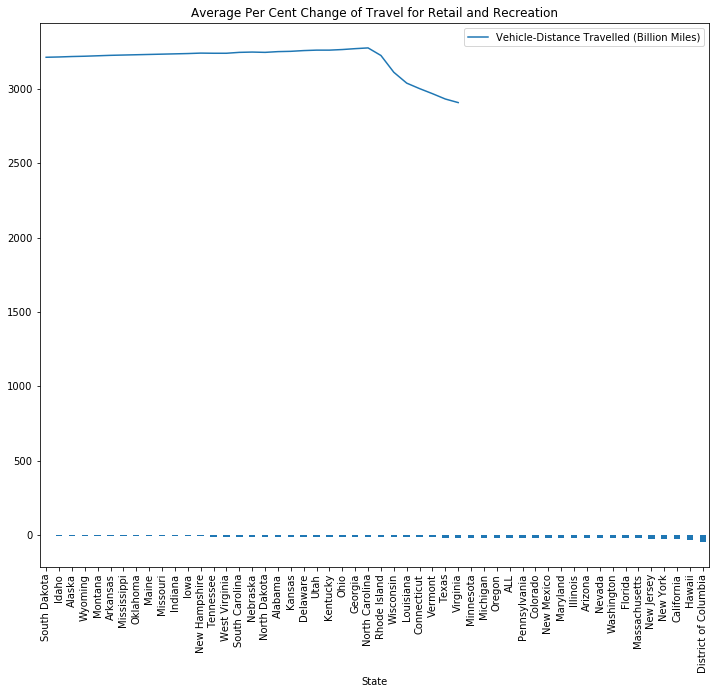

In [18]:
# Create panel for Unemployment visualizations
unemployment = pn.Row(unemployment_rate(),insurance_claims())

# Create panel for COVID & Mobility Visualizations
covid_data_plot = covid_data('Daily').hvplot.scatter(y=['total_cases'],
                                                     rot=90,
                                                     #xlim=(pd.to_datetime('2020-02-15'),pd.to_datetime('2020-10-31')),
                                                     xlabel = 'Date',
                                                     ylabel = 'No. of Cases',
                                                     height = 400,
                                                     width = 1200,
                                                     title = 'USA Total Cases 2020'
                                                    )

mobility_by_month_plot = mobility_data().hvplot.bar(x='date',
                                  y=('Retail_Recreation','Grocery_Pharmacy','Parks','Public_Transit','Workplaces'),
                                  rot=90,
                                  xlabel = 'Date',
                                  ylabel = 'Per Cent Change',
                                  height = 600,
                                  width=1200,
                                  title='Per Cent Change in Mobility')

vehicle_plot = vehicle_data().plot()

covid_mobility = pn.Column(covid_data_plot,mobility_by_month_plot,vehicle_plot)

# Create panel for Parallel Coordinates
cov_mob_parallel = pn.Column(covid_mobility_parallel())

# Create panel for Mobility and Vehicle Movement Analysis
statewise_mobility = pn.Column(mobility_retail_grocery(),mobility_mean_sort())


In [19]:
dashboard = pn.Tabs(
    ('Impact on Mobility',covid_mobility),
    ('Impact on Jobs',unemployment),
    ('Correlation Parallel',cov_mob_parallel),
    ('Statewise Mobility Impact', statewise_mobility),
    
)

In [20]:
dashboard.servable()

Tabs
    [0] Column
        [0] HoloViews(Scatter)
        [1] HoloViews(Bars)
        [2] Str(AxesSubplot)
    [1] Row
        [0] HoloViews(Bars)
        [1] HoloViews(Curve)
    [2] Column
        [0] Plotly(Figure)
    [3] Column
        [0] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='State', options=['ALL', 'Alabama', ...], value='ALL', width=250)
                [1] VSpacer()
        [1] Str(AxesSubplot)